<a href="https://colab.research.google.com/github/tomiock/DL2024-25/blob/main/Problems%208%20-%20Autoencoders/P8_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2024-25/blob/main/Problems%208%20-%20Autoencoders/P8_Autoencoders.ipynb)

# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# Setting up

In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.61MB/s]


# Simple Autoencoder

We will define a simple MLP Autoencoder

In [5]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [7]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

epoch : 1/10, Train loss = 0.048161
epoch : 1/10, Test loss = 0.024128


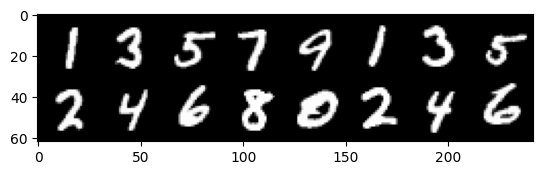

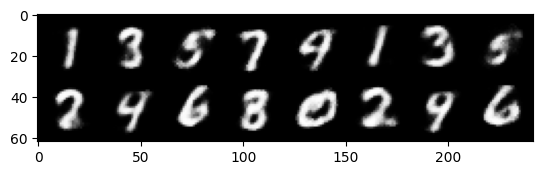

epoch : 2/10, Train loss = 0.019632
epoch : 2/10, Test loss = 0.015579


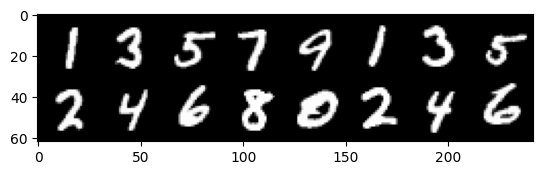

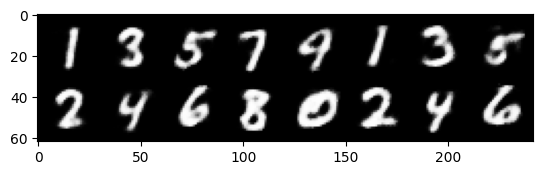

epoch : 3/10, Train loss = 0.014303
epoch : 3/10, Test loss = 0.012400


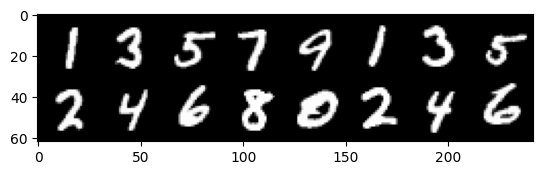

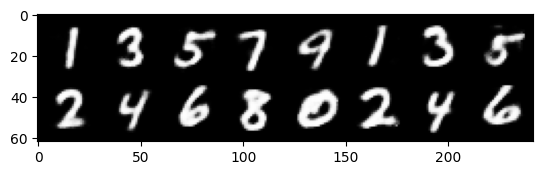

epoch : 4/10, Train loss = 0.011840
epoch : 4/10, Test loss = 0.010616


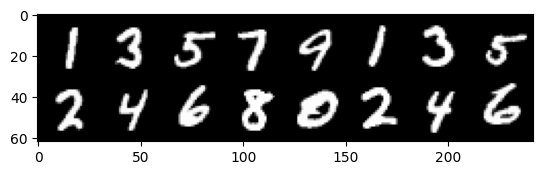

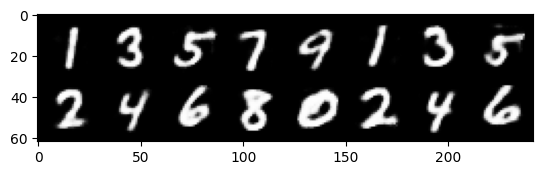

epoch : 5/10, Train loss = 0.010408
epoch : 5/10, Test loss = 0.009558


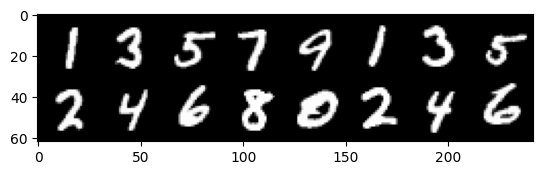

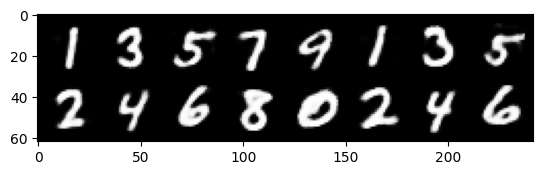

epoch : 6/10, Train loss = 0.009353
epoch : 6/10, Test loss = 0.008658


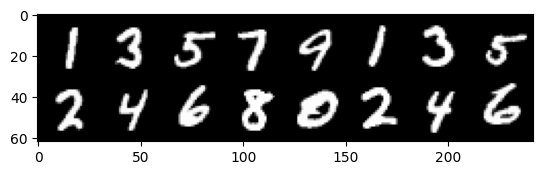

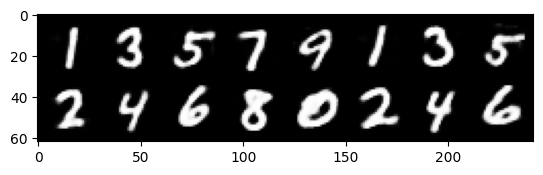

epoch : 7/10, Train loss = 0.008582
epoch : 7/10, Test loss = 0.008020


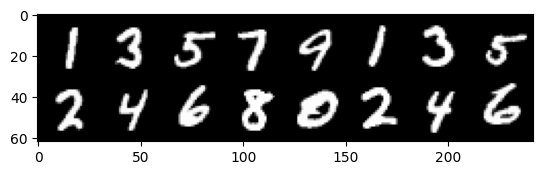

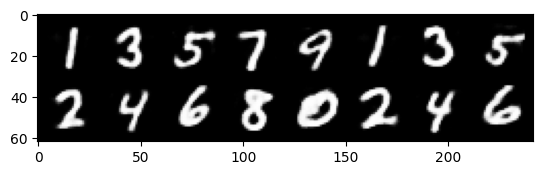

epoch : 8/10, Train loss = 0.007932
epoch : 8/10, Test loss = 0.007463


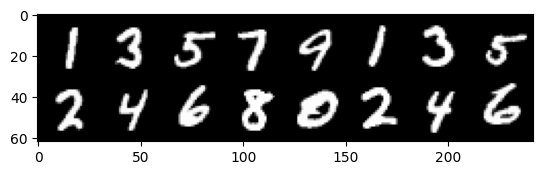

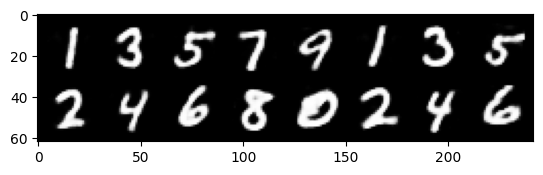

epoch : 9/10, Train loss = 0.007410
epoch : 9/10, Test loss = 0.006921


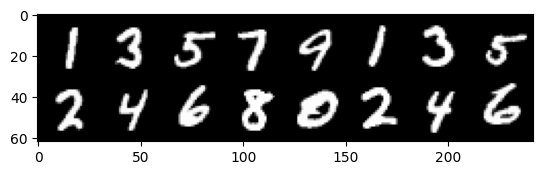

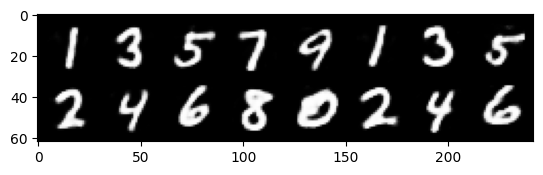

epoch : 10/10, Train loss = 0.006908
epoch : 10/10, Test loss = 0.006480


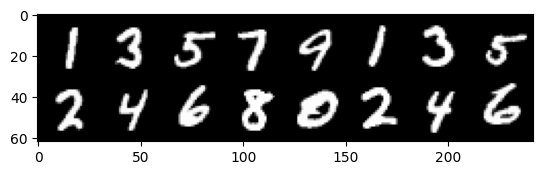

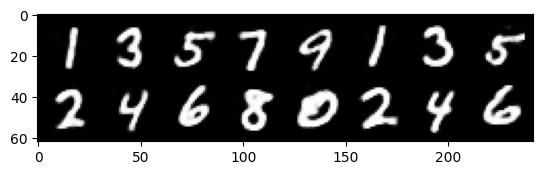

In [8]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True)

# Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [10]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<span style="color:blue">

**Exercise 1**: Build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> Hint: Use only deconvolutions (design an non-symmetric architecture) so that you do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> Hint: Remember that to calculate the new activation map's size while deconvolving you should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

epoch : 1/10, Train loss = 0.104761
epoch : 1/10, Test loss = 0.081431


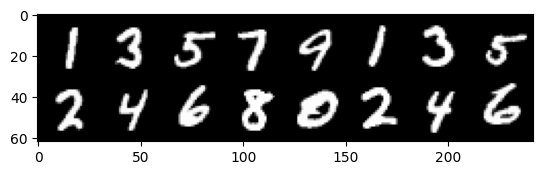

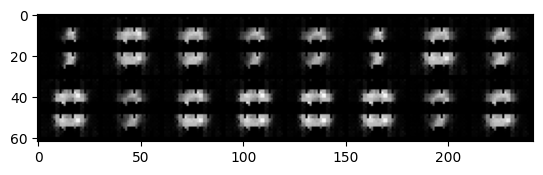

epoch : 2/10, Train loss = 0.061356
epoch : 2/10, Test loss = 0.048419


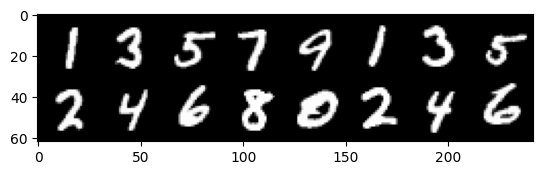

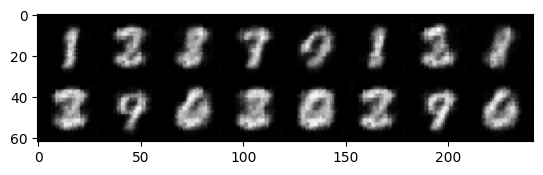

epoch : 3/10, Train loss = 0.044947
epoch : 3/10, Test loss = 0.041927


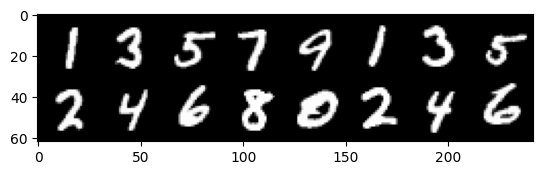

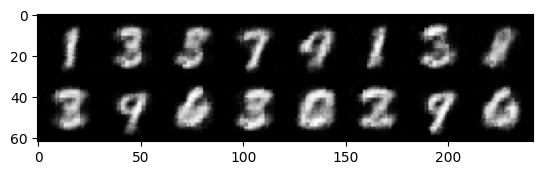

epoch : 4/10, Train loss = 0.040499
epoch : 4/10, Test loss = 0.038559


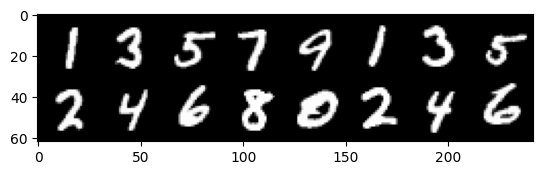

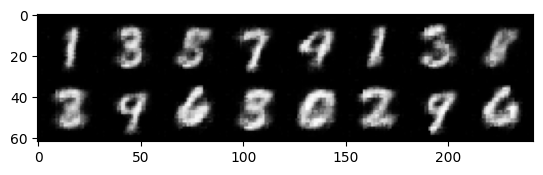

epoch : 5/10, Train loss = 0.037729
epoch : 5/10, Test loss = 0.036076


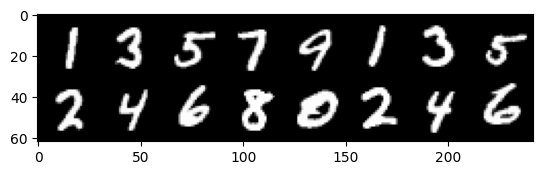

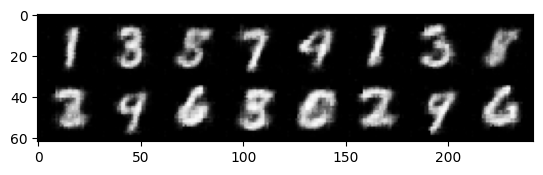

epoch : 6/10, Train loss = 0.035731
epoch : 6/10, Test loss = 0.034400


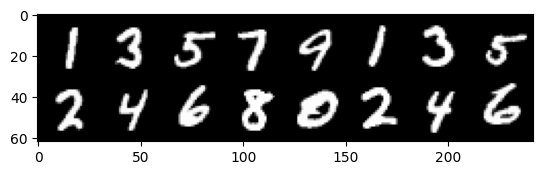

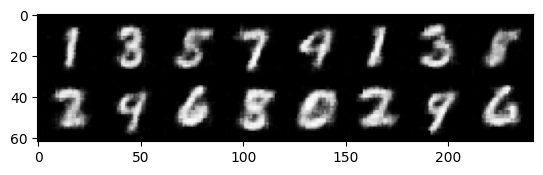

epoch : 7/10, Train loss = 0.034336
epoch : 7/10, Test loss = 0.033081


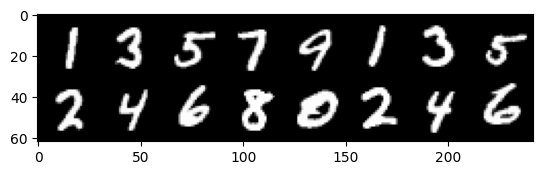

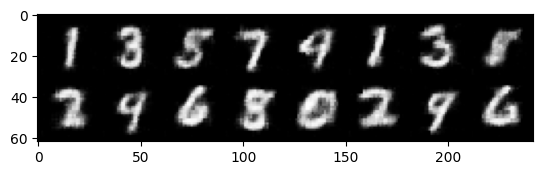

epoch : 8/10, Train loss = 0.033262
epoch : 8/10, Test loss = 0.032187


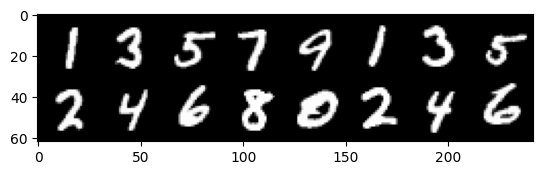

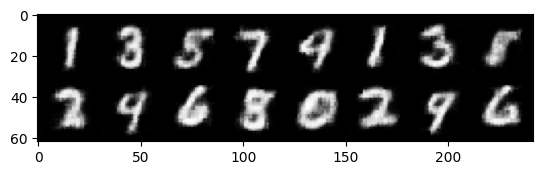

epoch : 9/10, Train loss = 0.032459
epoch : 9/10, Test loss = 0.031478


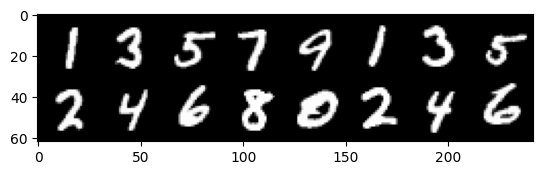

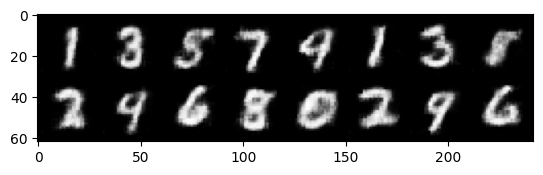

epoch : 10/10, Train loss = 0.031838
epoch : 10/10, Test loss = 0.030920


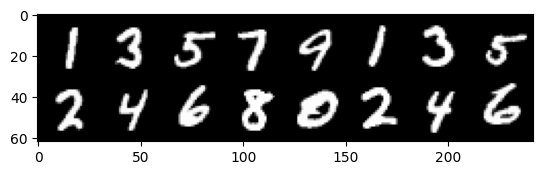

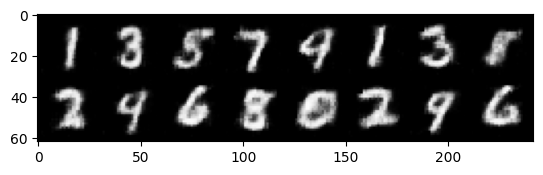

In [11]:
# Your code here
model = ConvAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader, criterion)

<span style="color:blue">

**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

In [12]:

class ConvAE2(nn.Module):
    def __init__(self):
        super(ConvAE2, self).__init__()

        # i encode
        self.conv1 = nn.Conv2d(1, 16, 3, stride=3, padding=1)  # b, 16, 10, 10
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) # b, 16, 5, 5
        self.conv2 = nn.Conv2d(16, 8, 3, stride=2, padding=1)  # b, 8, 3, 3
        self.pool2 = nn.MaxPool2d(2, stride=1, return_indices=True) # b, 8, 2, 2

        # and i decode
        self.unpool1 = nn.MaxUnpool2d(2, stride = 1)
        self.unconv1 = nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1)
        self.unpool2 = nn.MaxUnpool2d(2, stride = 2)
        self.unconv2 = nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1)

    def encode(self, x):
        x = torch.relu(self.conv1(x))
        x, self.indices1 = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x, self.indices2 = self.pool2(x)
        return x

    def decode(self, x):
        x = self.unpool1(x, self.indices2)
        x = torch.relu(self.unconv1(x))
        x = self.unpool2(x, self.indices1)
        x = torch.sigmoid(self.unconv2(x))
        return x

    def forward(self, x):
        # .... and together...
        # we ARE THE AUTOENCODER!
        x = self.encode(x)
        x = self.decode(x)
        return x

epoch : 1/10, Train loss = 0.203938
epoch : 1/10, Test loss = 0.144843


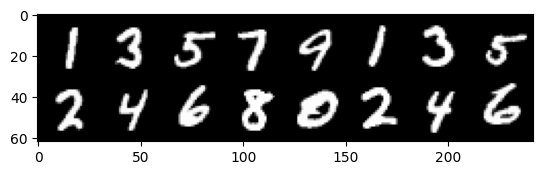

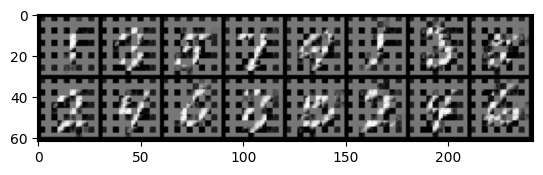

epoch : 2/10, Train loss = 0.120997
epoch : 2/10, Test loss = 0.101200


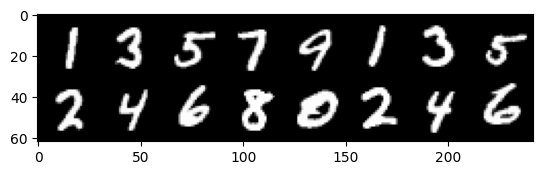

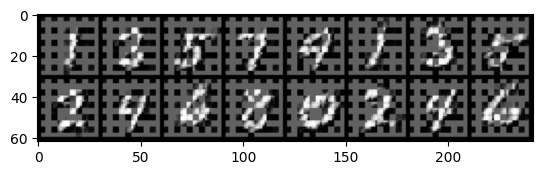

epoch : 3/10, Train loss = 0.087790
epoch : 3/10, Test loss = 0.076725


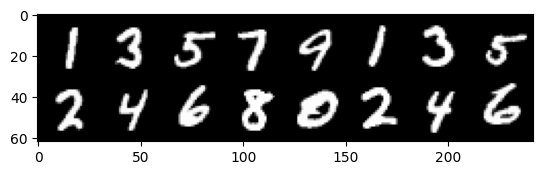

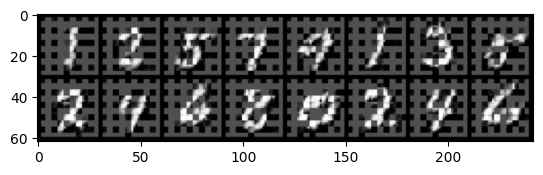

epoch : 4/10, Train loss = 0.068464
epoch : 4/10, Test loss = 0.061211


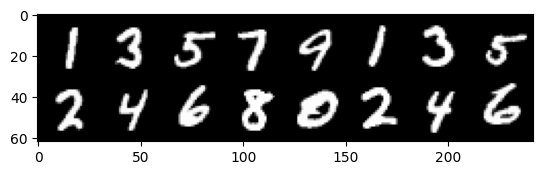

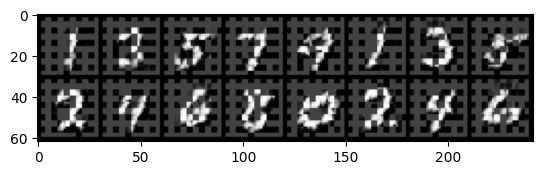

epoch : 5/10, Train loss = 0.055822
epoch : 5/10, Test loss = 0.051589


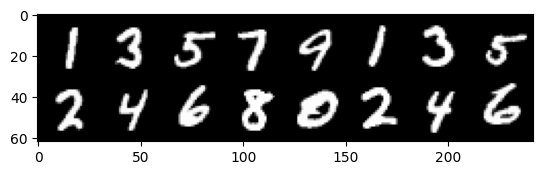

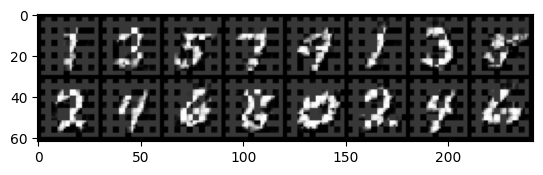

epoch : 6/10, Train loss = 0.047846
epoch : 6/10, Test loss = 0.044644


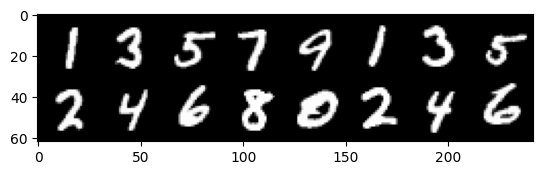

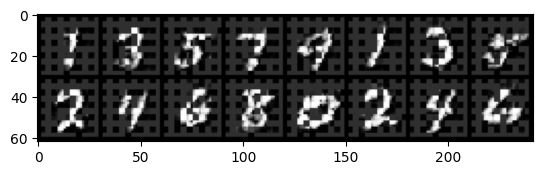

epoch : 7/10, Train loss = 0.041179
epoch : 7/10, Test loss = 0.036828


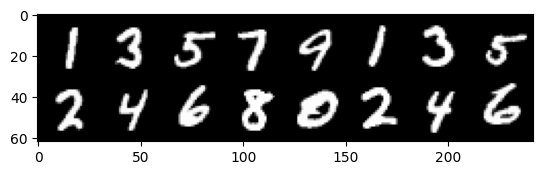

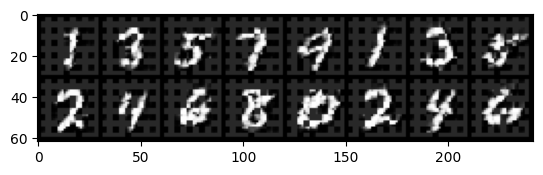

epoch : 8/10, Train loss = 0.033791
epoch : 8/10, Test loss = 0.031897


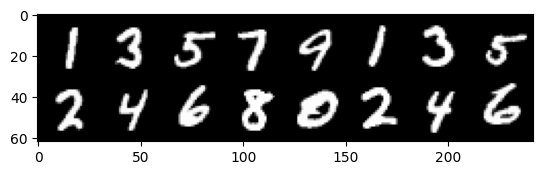

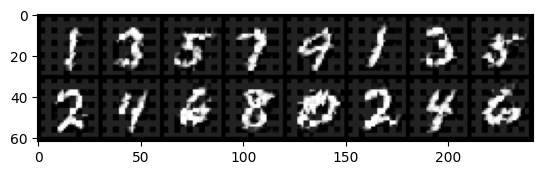

epoch : 9/10, Train loss = 0.030271
epoch : 9/10, Test loss = 0.028992


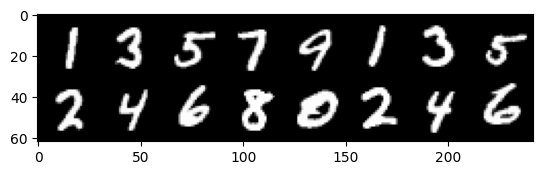

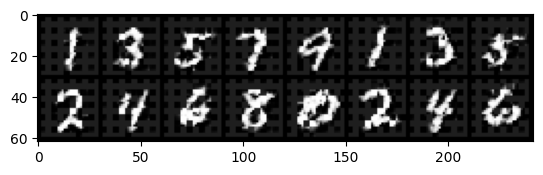

epoch : 10/10, Train loss = 0.027508
epoch : 10/10, Test loss = 0.026437


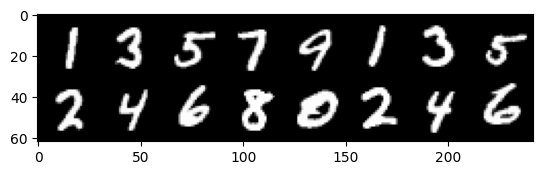

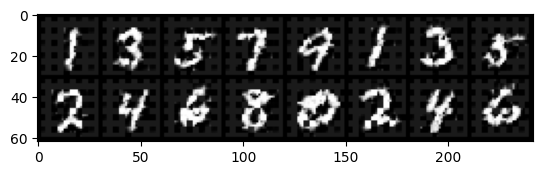

In [13]:
model = ConvAE2().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader, criterion)

# Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

In [14]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assumes a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by averaging.*

In [15]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [16]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [17]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

<ipython-input-14-f0bbe4192b33>:19: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  eps = torch.cuda.FloatTensor(std.size()).normal_()


epoch : 1/10, Train loss = 5796.226285
epoch : 1/10, Test loss = 1167.130948


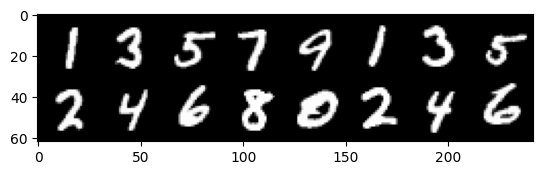

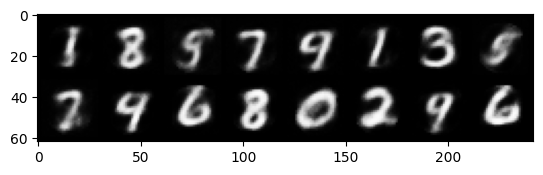

epoch : 2/10, Train loss = 4481.567151
epoch : 2/10, Test loss = 1073.234583


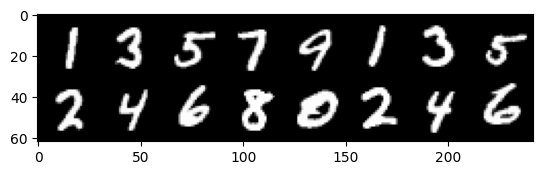

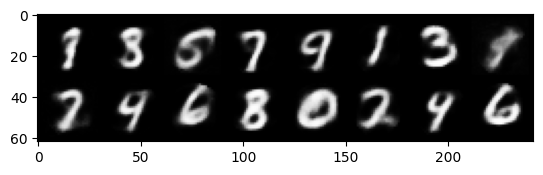

epoch : 3/10, Train loss = 4237.086394
epoch : 3/10, Test loss = 1031.970602


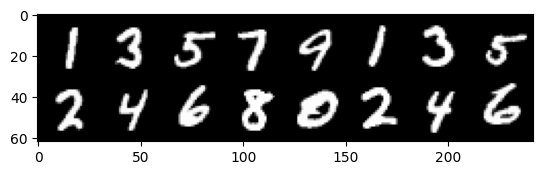

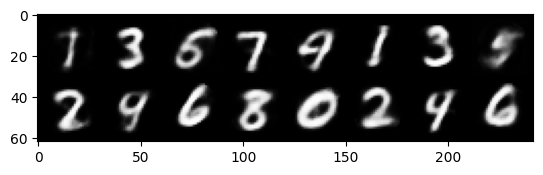

epoch : 4/10, Train loss = 4129.265903
epoch : 4/10, Test loss = 1012.326010


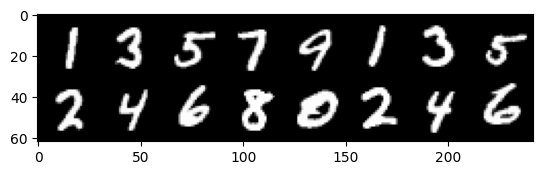

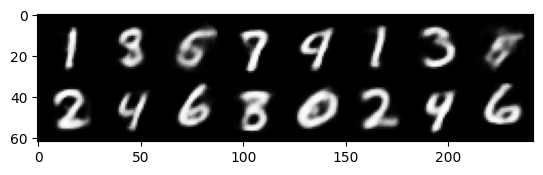

epoch : 5/10, Train loss = 4057.015277
epoch : 5/10, Test loss = 997.591087


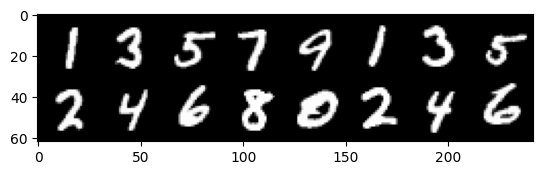

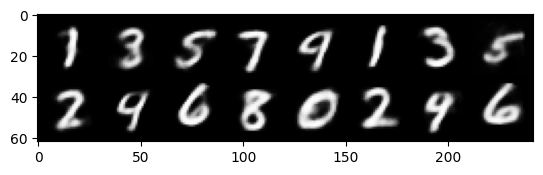

epoch : 6/10, Train loss = 4009.557127
epoch : 6/10, Test loss = 986.943930


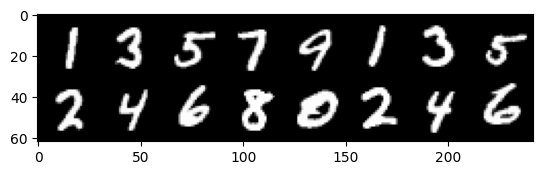

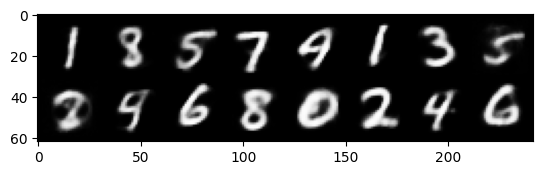

epoch : 7/10, Train loss = 3970.839131
epoch : 7/10, Test loss = 983.981222


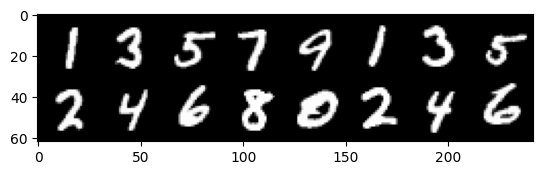

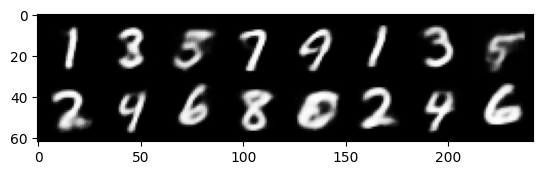

epoch : 8/10, Train loss = 3946.444538
epoch : 8/10, Test loss = 976.218087


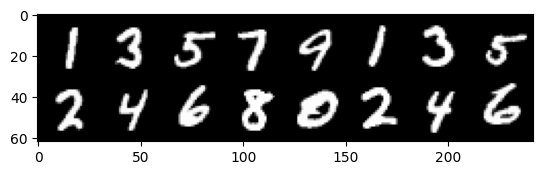

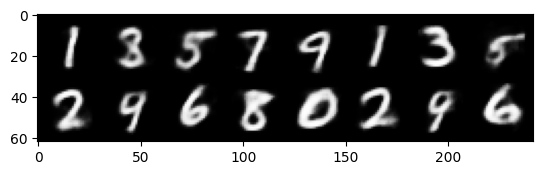

epoch : 9/10, Train loss = 3924.455631
epoch : 9/10, Test loss = 966.146668


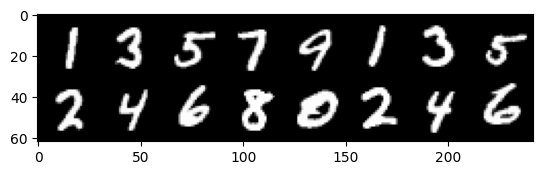

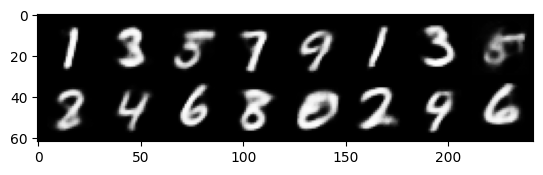

epoch : 10/10, Train loss = 3901.433785
epoch : 10/10, Test loss = 966.914800


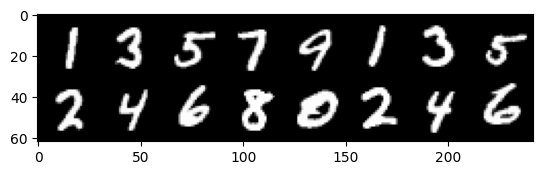

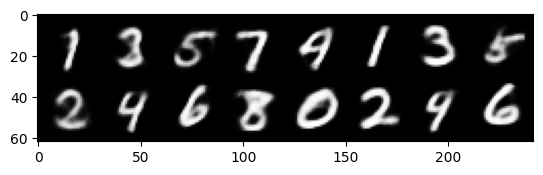

In [18]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion)

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [19]:
model.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits

    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])

        inter_image = inter_image.view(1, 28, 28)

        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show()

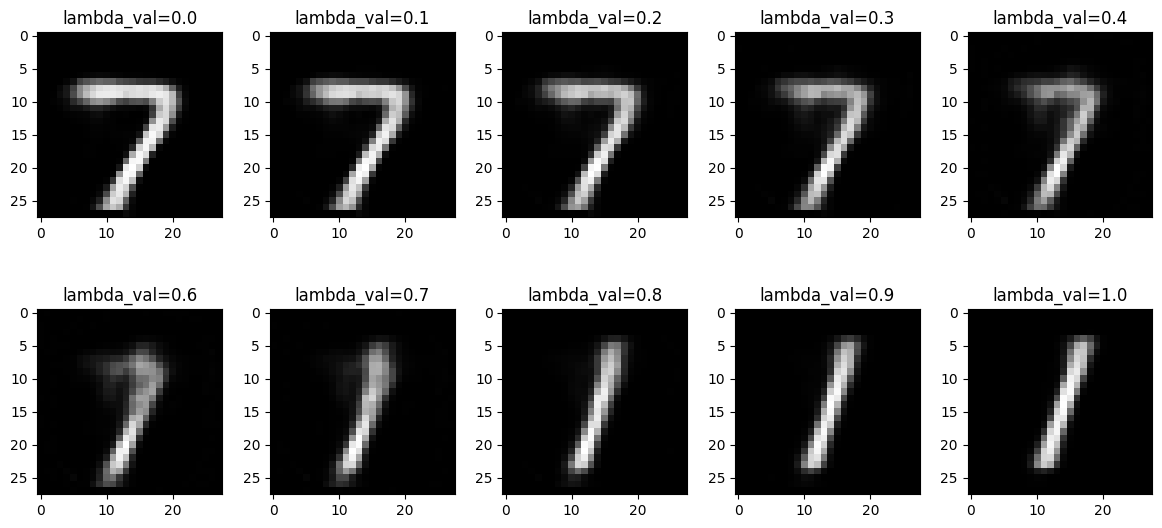

In [20]:
visualize_interpolation(model, test_loader, 7, 1)

<span style="color:blue">

**Exercise 3**: Use the already trained VAE model to generate 100 random new digits.

> Hint: Have a look at PyTorch's `randn()` https://pytorch.org/docs/stable/generated/torch.randn.html
    
</span>

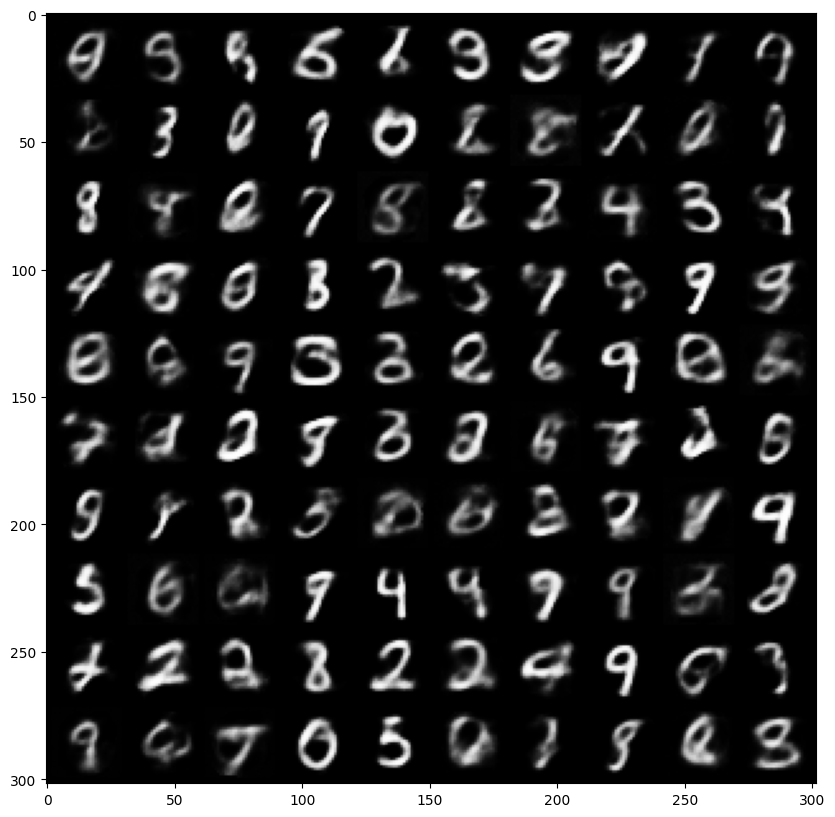

In [21]:
model.eval()
with torch.no_grad():
    latent = torch.randn(100, 20, device=device)

    img_recon = model.decode(latent)
    img_recon = img_recon.cpu()
    img_recon = img_recon.view(-1, 1, 28, 28)
    img_recon = img_recon.transpose(2, 3)

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(img_recon.data, nrow = 10))
    plt.show()



<span style="color:blue">

**Exercise 4**: Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

In [24]:
class VAE2(nn.Module):
    def __init__(self):
        super(VAE2, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)

        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [25]:
model2 = VAE2().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    train_vae(model2, train_loader, optimizer, loss_function)

epoch : 1/10, Train loss = 6275.551994
epoch : 2/10, Train loss = 5433.022551
epoch : 3/10, Train loss = 5283.141409
epoch : 4/10, Train loss = 5181.361416
epoch : 5/10, Train loss = 5108.931010
epoch : 6/10, Train loss = 5048.695950
epoch : 7/10, Train loss = 5006.782650
epoch : 8/10, Train loss = 4974.495703
epoch : 9/10, Train loss = 4944.310261
epoch : 10/10, Train loss = 4919.187395


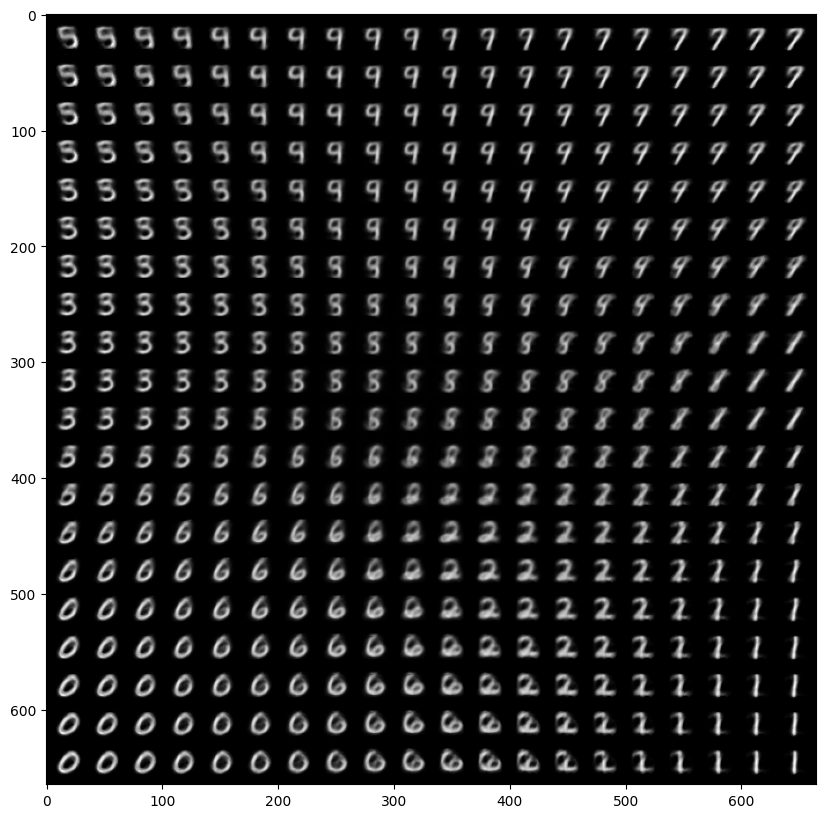

In [26]:
with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch


    latents = latents.to(device)
    image_recon = model2.decode(latents)
    image_recon = image_recon.cpu()
    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.view(-1, 1, 28, 28).transpose(2, 3), 20, 5))
    plt.show()

<span style="color:blue">

**Exercise 5**: Try both the simple encoder and the convolutional encoder with the FashionMNIST dataset, comment what you observe for both results.
    
</span>

In [28]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.8MB/s]


epoch : 1/10, Train loss = 0.037429
epoch : 1/10, Test loss = 0.021632


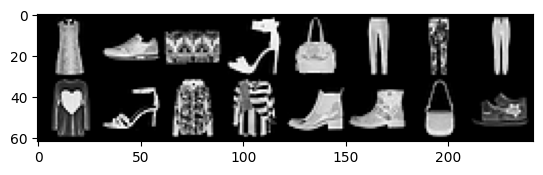

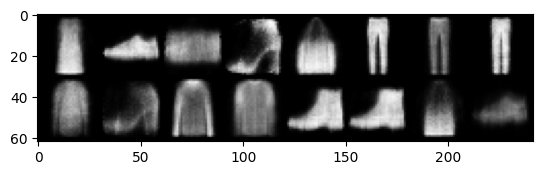

epoch : 2/10, Train loss = 0.019558
epoch : 2/10, Test loss = 0.018022


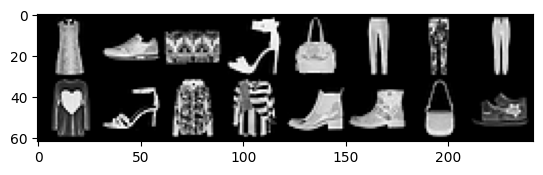

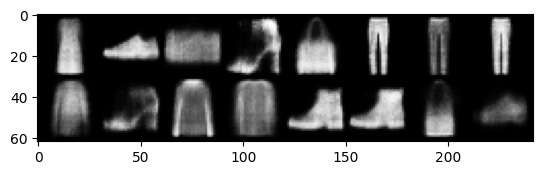

epoch : 3/10, Train loss = 0.016865
epoch : 3/10, Test loss = 0.015850


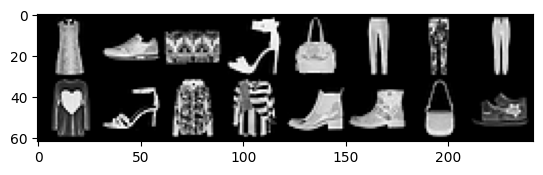

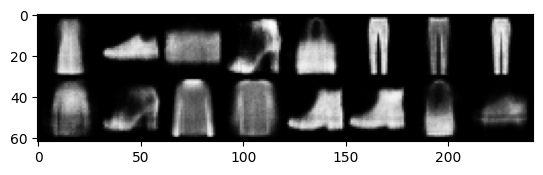

epoch : 4/10, Train loss = 0.015136
epoch : 4/10, Test loss = 0.014470


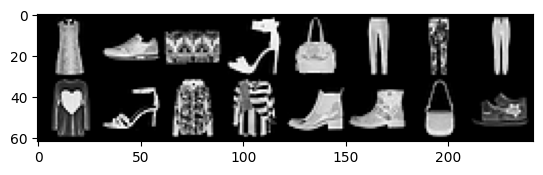

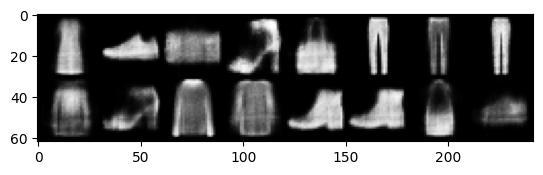

epoch : 5/10, Train loss = 0.013927
epoch : 5/10, Test loss = 0.013563


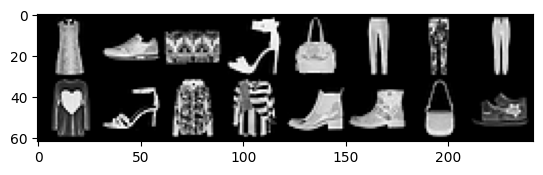

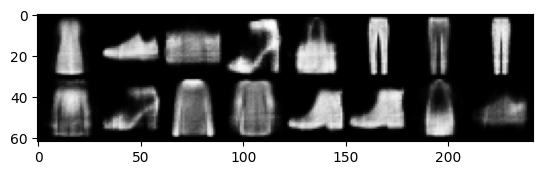

epoch : 6/10, Train loss = 0.013075
epoch : 6/10, Test loss = 0.012799


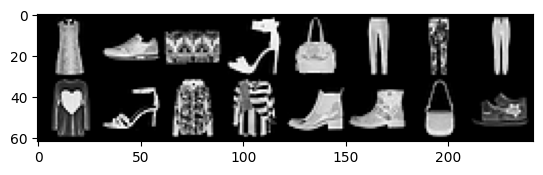

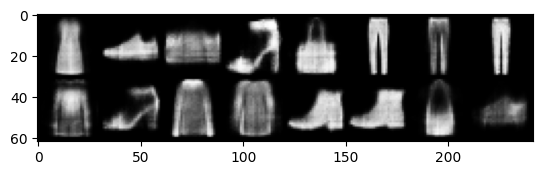

epoch : 7/10, Train loss = 0.012479
epoch : 7/10, Test loss = 0.012396


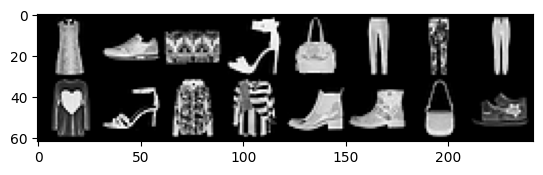

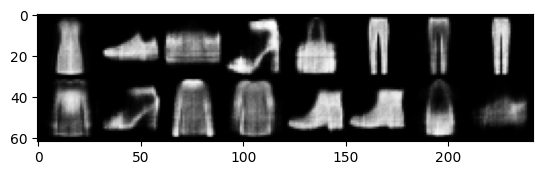

epoch : 8/10, Train loss = 0.011955
epoch : 8/10, Test loss = 0.011799


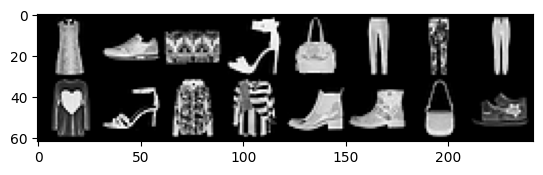

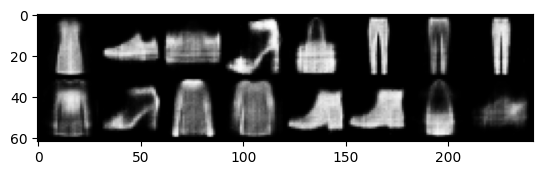

epoch : 9/10, Train loss = 0.011528
epoch : 9/10, Test loss = 0.011383


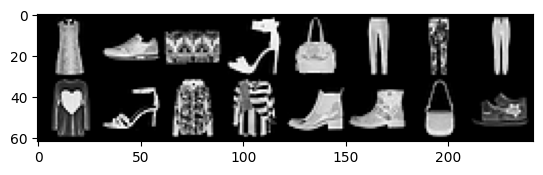

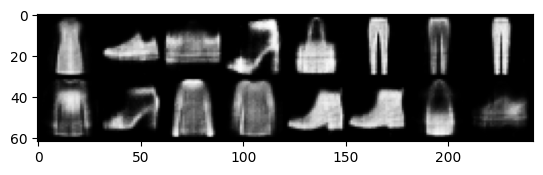

epoch : 10/10, Train loss = 0.011110
epoch : 10/10, Test loss = 0.011028


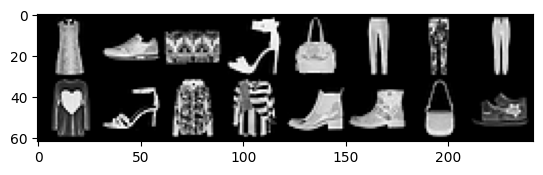

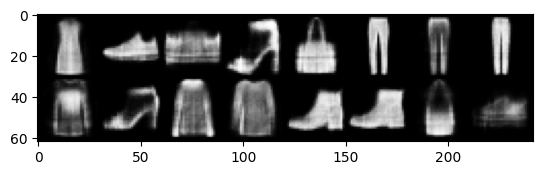

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(input_size=784).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model, train_loader_FMNIST, optimizer, criterion, reshape=True)
    test(model, test_loader_FMNIST, criterion, reshape=True)

epoch : 1/10, Train loss = 0.066493
epoch : 1/10, Test loss = 0.038909


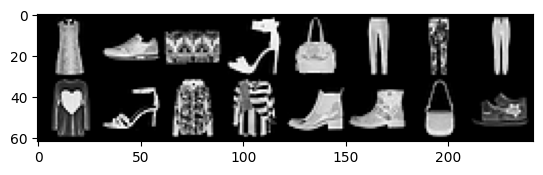

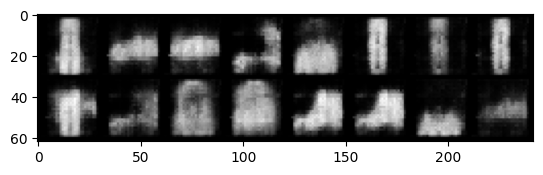

epoch : 2/10, Train loss = 0.035468
epoch : 2/10, Test loss = 0.032756


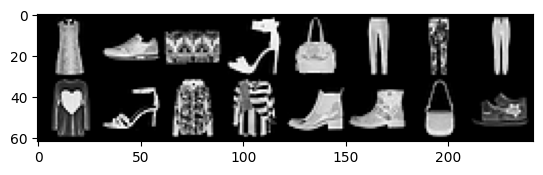

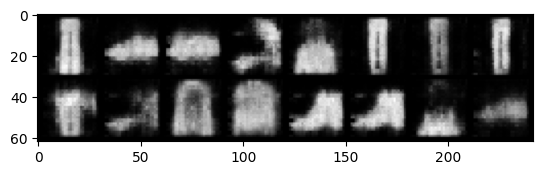

epoch : 3/10, Train loss = 0.031462
epoch : 3/10, Test loss = 0.030230


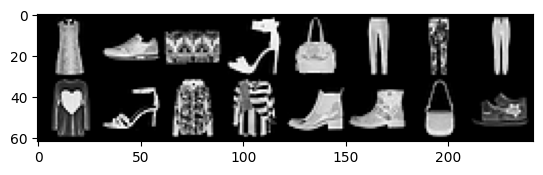

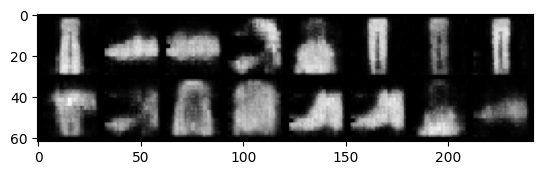

epoch : 4/10, Train loss = 0.029189
epoch : 4/10, Test loss = 0.028145


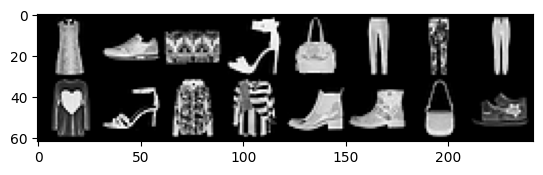

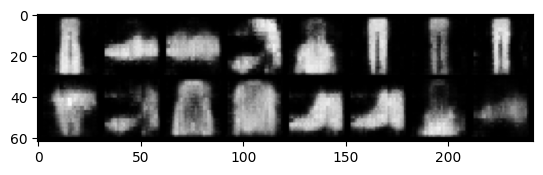

epoch : 5/10, Train loss = 0.027392
epoch : 5/10, Test loss = 0.026638


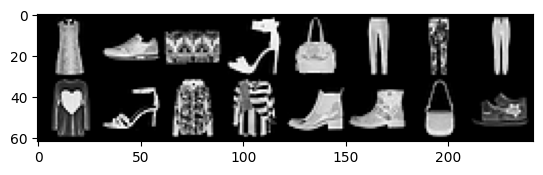

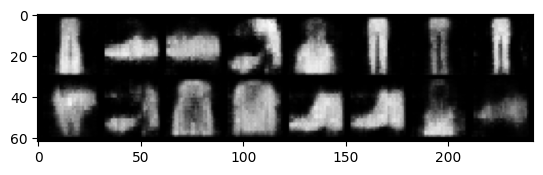

epoch : 6/10, Train loss = 0.026061
epoch : 6/10, Test loss = 0.025483


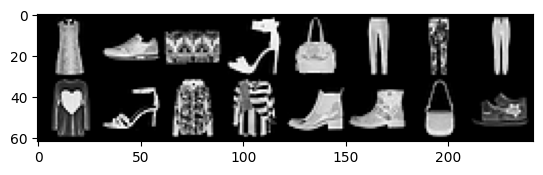

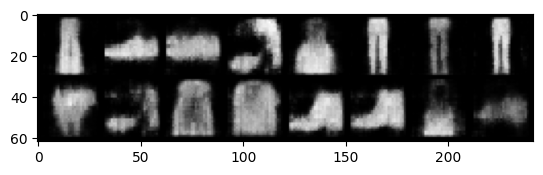

epoch : 7/10, Train loss = 0.024967
epoch : 7/10, Test loss = 0.024563


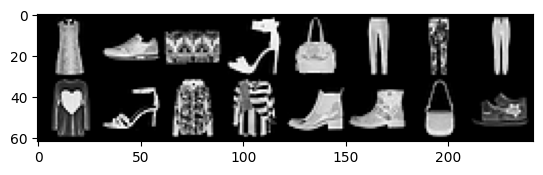

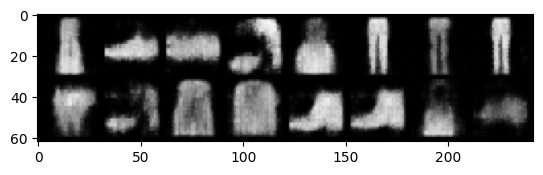

epoch : 8/10, Train loss = 0.024112
epoch : 8/10, Test loss = 0.023813


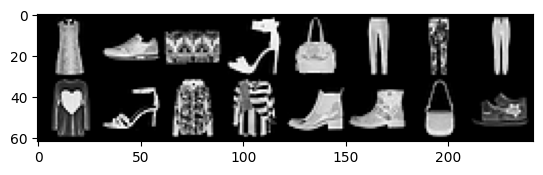

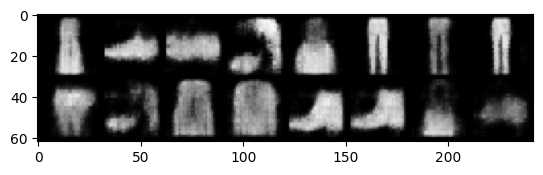

epoch : 9/10, Train loss = 0.023478
epoch : 9/10, Test loss = 0.023262


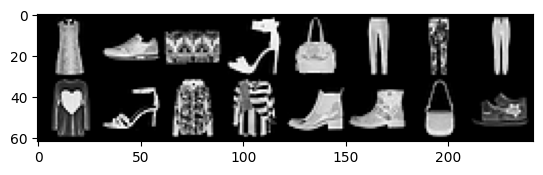

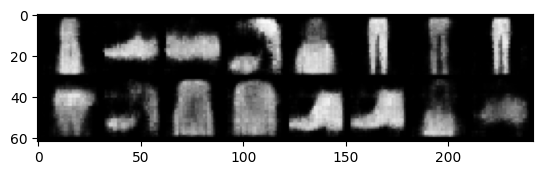

epoch : 10/10, Train loss = 0.022966
epoch : 10/10, Test loss = 0.022827


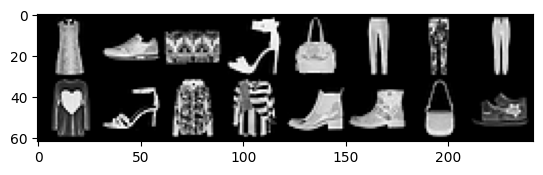

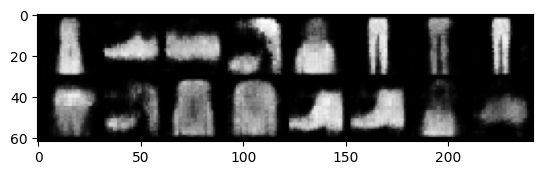

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model, train_loader_FMNIST, optimizer, criterion)
    test(model, test_loader_FMNIST, criterion)